<a href="https://colab.research.google.com/github/AI-Unibo-Projects/Deep-Learning-Project/blob/4_model/FaceGenerator_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instructions


<h3>  &nbsp;&nbsp;Train on TPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

## Enabling and testing the TPU

We'll check that we can connect to the TPU:

In [1]:
"""is_colab = True
try:
    import google.colab
except:
    is_colab = False"""

is_colab = False
    
if is_colab:
    %tensorflow_version 2.x
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
        
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    batch_size = 16 * tpu_strategy.num_replicas_in_sync
else:
    import tensorflow as tf
    print("Tensorflow version " + tf.__version__)
    batch_size = 16

buffer_size = 60000
tf.keras.backend.clear_session()  # For easy reset of notebook state.

Tensorflow version 2.2.0-rc3


In [0]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers
import os
import time


## Input data

Our input data is stored on Google Cloud Storage. To more fully use the parallelism TPUs offer us, and to avoid bottlenecking on data transfer, we've stored our input data in TFRecord files, 2025 images per file.

Below, we make heavy use of `tf.data.experimental.AUTOTUNE` to optimize different parts of input loading.


In [3]:
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [64, 64]

gcs_pattern = 'gs://celeba-public/tfrecord_*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)

def parse_attribute_list(example):
  features = {
      "names": tf.io.FixedLenFeature([], tf.string),
  }

  example = tf.io.parse_single_example(example, features)
  attributes_names = example['names']
  return attributes_names

def get_names():
  record = tf.data.TFRecordDataset('gs://celeba-test/attribute_list.tfrec')
  attributes = record.map(parse_attribute_list)
  att_names = next(attributes.as_numpy_iterator()).decode("utf-8")
  att_names_list = [elem.strip()[1:-1] for elem in att_names.split(',')]
  return att_names_list

att_names_list = get_names()


feature_dict = {
      "filename": tf.io.FixedLenFeature([], tf.string),
      "height": tf.io.FixedLenFeature([], tf.int64),
      "width": tf.io.FixedLenFeature([], tf.int64),
      "depth": tf.io.FixedLenFeature([], tf.int64),
      "image": tf.io.FixedLenFeature([], tf.string),
  }

attributes_dict = dict(zip(att_names_list, [tf.io.FixedLenFeature([], tf.int64) for elem in att_names_list]))

feature_dict.update(attributes_dict) 

def parse_tfrecord(example):
  features = feature_dict
  example = tf.io.parse_single_example(example, features)
  #filename = example['filename']
  width = tf.cast(example['width'],tf.int64)
  height = tf.cast(example['height'],tf.int64)
  decoded = tf.image.decode_image(example['image'])  
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [height, width, 3])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], IMAGE_SIZE) # crop and reshape the image 
  #attr_dict = {}
  #for name in att_names_list:
  #  attr_dict[name] = example[name]

  # return filename, image_tensor, attr_dict
  return image_tensor

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

dataset = load_dataset(filenames).batch(batch_size)
dataset.shuffle(buffer_size)
print(type(dataset))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


Let's take a peek at the dataset we've created:

In [0]:
def display_images(images, n):
  plt.figure(figsize=(13,13))
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, i+1)
    # turn off axis
    plt.axis('off')
    plt.imshow(images[i])
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

training_viz_iterator = get_dataset_iterator(dataset, 100)

In [0]:
"""# Re-run this cell to show a new batch of images
name, images, attr = next(training_viz_iterator)
print('Image name {}\n'.format(name[0]))
for name in attr.keys():
  print('{}: {}\n'.format(name, attr[name][0]))
display_images(images, 10)"""

"# Re-run this cell to show a new batch of images\nname, images, attr = next(training_viz_iterator)\nprint('Image name {}\n'.format(name[0]))\nfor name in attr.keys():\n  print('{}: {}\n'.format(name, attr[name][0]))\ndisplay_images(images, 10)"

## Model


In [0]:
def create_generator():
  """
  model = tf.keras.Sequential()
  model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,))) # input_shape is the noise seed
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((8, 8, 256)))
  assert model.output_shape == (None, 8, 8, 256) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 32)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 64, 64, 3)
  """

  input_layer = layers.Input(shape=(100,))
  x = layers.Dense(8*8*256, use_bias=False)(input_layer) # input_shape is the noise seed
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  reshape = layers.Reshape((8, 8, 256))
  x = reshape(x)
  # assert reshape.output_shape == (None, 8, 8, 256) # Note: None is the batch size
  
  conv2dtranspose_1 = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)
  x = conv2dtranspose_1(x)
  # assert conv2dtranspose_1.output_shape == (None, 8, 8, 128)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  conv2dtranspose_2 = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
  x = conv2dtranspose_2(x)
  # assert conv2dtranspose_2.output_shape == (None, 16, 16, 64)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)
  
  conv2dtranspose_3 = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)
  x = conv2dtranspose_3(x)
  # assert conv2dtranspose_3.output_shape == (None, 32, 32, 32)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  conv2dtranspose_4 = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False)
  x = conv2dtranspose_4(x)
  # assert conv2dtranspose_4.output_shape == (None, 64, 64, 3)
  output_layer = layers.Activation(activation='tanh')(x)

  model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer], name="generator")

  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4))

  return model

In [0]:
def create_discriminator():
  """
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                    input_shape=[64, 64, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  """

  input_layer = layers.Input(shape=[64, 64, 3])
  
  x = layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')(input_layer)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Flatten()(x)
  output_layer= layers.Dense(1)(x)

  model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer], name="discriminator")

  model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4))

  return model

tf.Tensor([[0.00082181]], shape=(1, 1), dtype=float32)
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_16 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
ba

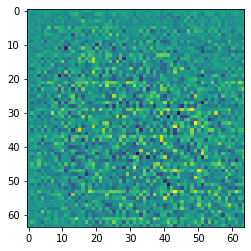

In [17]:
#with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
generator = create_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

discriminator = create_discriminator()
decision = discriminator(generated_image)
print (decision)

generator.summary()
discriminator.summary()

In [0]:
# This method returns a helper function to compute cross entropy loss
#with tpu_strategy.scope():
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
"""checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)"""

'checkpoint_dir = \'/training_checkpoints\'\ncheckpoint_prefix = os.path.join(checkpoint_dir, "ckpt")\ncheckpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,\n                                 discriminator_optimizer=discriminator_optimizer,\n                                 generator=generator,\n                                 discriminator=discriminator)'

## Training

In [0]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
      print("bo")

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [16]:
# with tpu_strategy.scope():
train(dataset, epochs)

bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo
bo


KeyboardInterrupt: ignored

## Results